# Optimizer and schedule effects (NumPy only)

This notebook shows why we use Adam, learning-rate schedules, and early stopping by comparing them side by side on the same preprocessed dataset, using the repo's implementations.



What you'll see:

- Gradient Descent (GD) vs Adam: optimization speed and stability

- Schedules: none vs cosine (how LR decay improves convergence)

- Early stopping: detecting overfitting on a held-out validation set



Outputs:

- Figures are saved to `notebook/picture/`

- Histories (optional) saved to `notebook/data_saving/`



Tip: Ensure `run.py` has produced `data_saving/preproc_data_2.npz` (or point the notebook to another preprocessed cache).

In [1]:
# 1) Imports and setup (NumPy + repo modules)

import os, json, time, math, random, sys

from pathlib import Path

import numpy as np

import matplotlib

import matplotlib.pyplot as plt

# Ensure inline display in notebooks

try:

    from IPython import get_ipython

    ip = get_ipython()

    if ip is not None:

        ip.run_line_magic('matplotlib', 'inline')

except Exception:

    pass



# Robust project root detection from the 'notebook' folder

ROOT = None

candidates = [Path.cwd()] + list(Path.cwd().parents)

for _p in candidates:

    if (_p / "config.py").exists() and (_p / "implementations.py").exists():

        ROOT = _p

        if str(_p) not in sys.path:

            sys.path.insert(0, str(_p))

        break

if ROOT is None:

    ROOT = Path.cwd().parent



import config

import implementations

import cv_utils

import metrics



SEED = getattr(config, 'RNG_SEED', 42)

random.seed(SEED)

np.random.seed(SEED)



# Output folders under notebook/

BASE = ROOT / 'notebook'

PICT_DIR = BASE / 'picture'

DATA_DIR = BASE / 'data_saving'

PICT_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
# 2) Chargement des données prétraitées (PREPROC2) et split train/val
# Préfère config.PREPROC2_DATA_PATH; fallback vers data_saving/preprocessed_data.npz
npz_candidates = []
try:
    cfg_rel = Path(config.PREPROC2_DATA_PATH)
    npz_candidates.append((ROOT / cfg_rel))
except Exception:
    pass
npz_candidates.append(ROOT / 'data_saving' / 'preproc_data_2.npz')
npz_candidates.append(ROOT / 'data_saving' / 'preprocessed_data.npz')
NPZ_PATH = None
for cand in npz_candidates:
    if cand.exists():
        NPZ_PATH = cand
        break
if NPZ_PATH is None:
    raise FileNotFoundError('Aucun cache PREPROC2 trouvé. Exécutez run.py pour générer data_saving/preproc_data_2.npz')
npz = np.load(NPZ_PATH, allow_pickle=False)
X_train = npz['X_train'].astype(np.float32)
X_test  = npz['X_test'].astype(np.float32)
y_train = npz['y_train'].astype(np.int32)
train_ids = npz['train_ids']
test_ids  = npz['test_ids']

val_frac = 0.1
n = y_train.size
idx = np.arange(n)
rng = np.random.RandomState(SEED)
rng.shuffle(idx)
n_val = int(n * val_frac)
val_idx = idx[:n_val]; tr_idx = idx[n_val:]
X_tr, y_tr = X_train[tr_idx], y_train[tr_idx]
X_va, y_va = X_train[val_idx], y_train[val_idx]

cap = 30000
if X_tr.shape[0] > cap:
    sel = rng.choice(X_tr.shape[0], size=cap, replace=False)
    X_tr = X_tr[sel]; y_tr = y_tr[sel]

In [3]:
# 3) Define experiments (optimizers and schedules)

def schedule_none(lr0, t, T):

    return lr0



def schedule_cosine(lr0, t, T):

    return lr0 * 0.5 * (1.0 + math.cos(math.pi * t / max(1, T)))



experiments = [

    {'name': 'GD_none',   'adam': False, 'schedule': None,           'early_stop': False},

    {'name': 'Adam_none', 'adam': True,  'schedule': None,           'early_stop': False},

    {'name': 'Adam_cos',  'adam': True,  'schedule': schedule_cosine,'early_stop': False},

    {'name': 'Adam_cos_ES','adam': True, 'schedule': schedule_cosine,'early_stop': True},

]

print('Experiments:', ', '.join(e['name'] for e in experiments))

Experiments: GD_none, Adam_none, Adam_cos, Adam_cos_ES


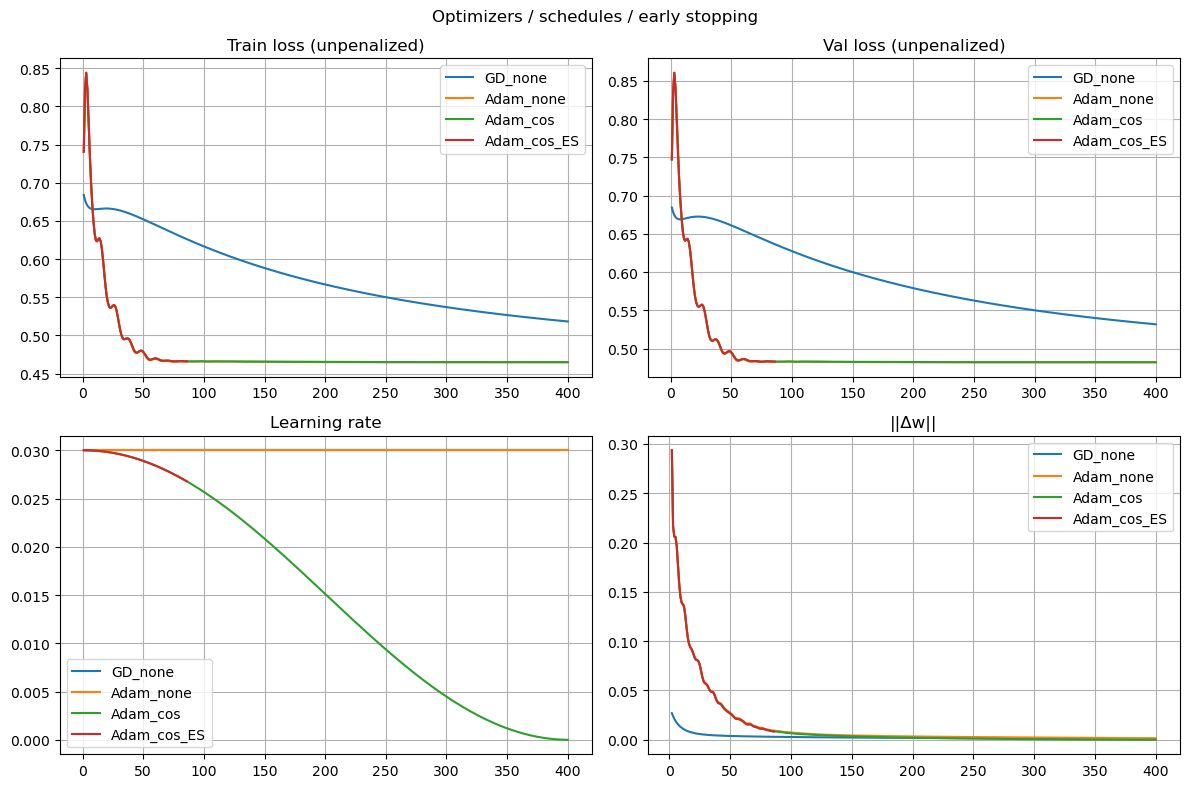

Saved figure -> c:\Users\alexb\OneDrive - Université Libre de Bruxelles\MA2 EPFL\CS-433\Projects\Project 1\notebook\picture\optimizer_compare_numpy.png
GD_none: val_acc=0.8539 val_f1=0.4158 final_loss=0.5183
Adam_none: val_acc=0.8585 val_f1=0.4138 final_loss=0.4649
Adam_cos: val_acc=0.8609 val_f1=0.4142 final_loss=0.4651
Adam_cos_ES: val_acc=0.8641 val_f1=0.4168 final_loss=0.4660


In [4]:
# 4) Train with callback and save histories; show and save plots

plt.ioff()  # keep figures from popping during batch saves; we'll also display explicitly



def run_one(Xtr, ytr, Xva, yva, adam, schedule, early_stop, max_iters=400, gamma=3e-2, lambda_=1e-4,

            patience=10, tol=1e-6):

    """Train one configuration and return weights, metrics, and history.

    History keys: iter, loss (train, unpenalized), lr, grad_norm, update_norm, val_loss (unpenalized)

    """

    hist = {'iter': [], 'loss': [], 'lr': [], 'update_norm': [], 'grad_norm': [], 'val_loss': []}

    prev_w = None

    def grad_norm_at(w):

        g = implementations.logistic_gradient(ytr, Xtr, w, lambda_=0)

        return float(np.linalg.norm(g))

    def cb(t, w, loss, lr):

        nonlocal prev_w

        un = float(np.linalg.norm(w - prev_w)) if prev_w is not None else float('nan')

        gn = grad_norm_at(w)

        hist['iter'].append(int(t)); hist['loss'].append(float(loss)); hist['lr'].append(float(lr))

        hist['update_norm'].append(un); hist['grad_norm'].append(gn)

        # validation loss (unpenalized/unweighted)

        vloss = float(implementations.logistic_loss(yva, Xva, w, lambda_=0))

        hist['val_loss'].append(vloss)

        prev_w = w.copy()

    w0 = np.zeros(Xtr.shape[1], dtype=np.float32)

    w, final_loss = implementations.reg_logistic_regression(

        ytr, Xtr, lambda_, w0, max_iters=max_iters, gamma=gamma, adam=adam,

        schedule=schedule, early_stopping=early_stop, patience=patience, tol=tol,

        verbose=False, callback=cb

    )

    probs = implementations.sigmoid(Xva.dot(w))

    thr, p, r, f1 = cv_utils.best_threshold_by_f1(yva, probs)

    preds = (probs >= thr).astype(int)

    acc = metrics.accuracy_score(yva, preds)

    return w, final_loss, acc, f1, hist



MAX_ITERS = 400

GAMMA = 3e-2

LAMBDA = 1e-4



results = {}

for exp in experiments:

    w, fl, acc, f1, hist = run_one(

        X_tr, y_tr, X_va, y_va,

        adam=exp['adam'], schedule=exp['schedule'], early_stop=exp['early_stop'],

        max_iters=MAX_ITERS, gamma=GAMMA, lambda_=LAMBDA,

        patience=10, tol=1e-6

    )

    results[exp['name']] = {'w': w, 'final_loss': fl, 'val_acc': acc, 'val_f1': f1, 'hist': hist}



# Save histories

np.savez(DATA_DIR / 'optimizer_viz_histories.npz', **{k: results[k]['hist'] for k in results})



# 5) Visualization: Loss, Val Loss, LR, Update Norm

def plot_hist(hist_dict, title, save_name):

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Train loss

    for name, res in hist_dict.items():

        h = res['hist']

        axes[0,0].plot(h['iter'], h['loss'], label=name)

    axes[0,0].set_title('Train loss (unpenalized)'); axes[0,0].legend(); axes[0,0].grid(True)

    # Val loss

    for name, res in hist_dict.items():

        h = res['hist']

        axes[0,1].plot(h['iter'], h['val_loss'], label=name)

    axes[0,1].set_title('Val loss (unpenalized)'); axes[0,1].legend(); axes[0,1].grid(True)

    # LR

    for name, res in hist_dict.items():

        h = res['hist']

        axes[1,0].plot(h['iter'], h['lr'], label=name)

    axes[1,0].set_title('Learning rate'); axes[1,0].legend(); axes[1,0].grid(True)

    # Update norm

    for name, res in hist_dict.items():

        h = res['hist']

        axes[1,1].plot(h['iter'], h['update_norm'], label=name)

    axes[1,1].set_title('||Δw||'); axes[1,1].legend(); axes[1,1].grid(True)

    fig.suptitle(title)

    fig.tight_layout()

    out = PICT_DIR / save_name

    fig.savefig(out)

    plt.show()

    return out



out_path = plot_hist(results, 'Optimizers / schedules / early stopping', 'optimizer_compare_numpy.png')

print(f'Saved figure -> {out_path}')

for name, res in results.items():

    print(f"{name}: val_acc={res['val_acc']:.4f} val_f1={res['val_f1']:.4f} final_loss={res['final_loss']:.4f}")

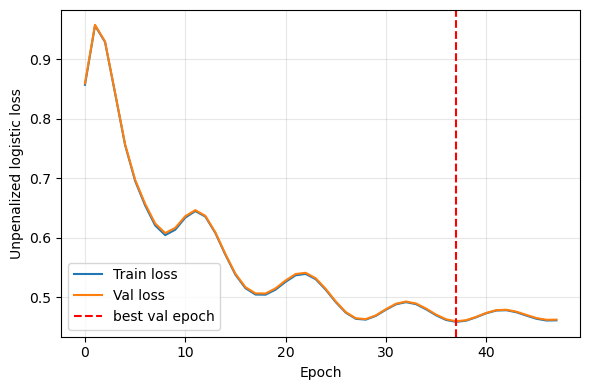

Saved final training curve figure -> c:\Users\alexb\OneDrive - Université Libre de Bruxelles\MA2 EPFL\CS-433\Projects\Project 1\notebook\picture\final_training_curve.png | best_val_epoch=37 best_val_loss=0.459816


In [5]:
# 6) (Optional) Inspect the final training curves saved by run.py

NPZ_CURVE = ROOT / 'data_saving' / 'final_training_curve.npz'

if NPZ_CURVE.exists():

    D = np.load(NPZ_CURVE, allow_pickle=False)

    lt = D.get('loss_train', None)

    lv = D.get('loss_val', None)

    lr = D.get('lr', None)

    bve = int(D.get('best_val_epoch', -1))

    bvl = float(D.get('best_val_loss', np.nan))

    if lt is not None and lv is not None:

        plt.figure(figsize=(6,4))

        plt.plot(lt, label='Train loss')

        plt.plot(lv, label='Val loss')

        if bve >= 0:

            plt.axvline(bve, color='r', ls='--', label='best val epoch')

        plt.xlabel('Epoch')

        plt.ylabel('Unpenalized logistic loss')

        plt.grid(True, alpha=0.3)

        plt.legend()

        plt.tight_layout()

        out = PICT_DIR / 'final_training_curve.png'

        plt.savefig(out)

        plt.show()

        print(f'Saved final training curve figure -> {out} | best_val_epoch={bve} best_val_loss={bvl:.6f}')

    if lr is not None and lr.size > 0:

        plt.figure(figsize=(6,4))

        plt.plot(lr, label='LR')

        plt.xlabel('Epoch')

        plt.ylabel('Learning rate')

        plt.grid(True, alpha=0.3)

        plt.legend()

        plt.tight_layout()

        out = PICT_DIR / 'final_training_lr.png'

        plt.savefig(out)

        plt.show()

        print(f'Saved LR curve figure -> {out}')

else:

    print(f"[INFO] No curve file found at {NPZ_CURVE}; run run.py with DO_SUBMISSION=True and HOLDOUT_VAL_FRAC>0")

In [6]:
# Comparison: standard BCE vs weighted BCE vs focal loss on one fold
# Reuses X_tr, y_tr, X_va, y_va prepared above.
import numpy as np

_EPS = 1e-12

def nb_sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def nb_bce_mean(y, p):
    p = np.clip(p, _EPS, 1.0 - _EPS)
    return np.mean(-(y * np.log(p) + (1.0 - y) * np.log(1.0 - p)))

def nb_class_weights(y):
    n = y.size
    pos = np.sum(y == 1)
    neg = n - pos
    # Balanced weights with mean ~1 when averaged over samples
    w_pos = n / (2.0 * pos) if pos > 0 else 1.0
    w_neg = n / (2.0 * neg) if neg > 0 else 1.0
    return w_neg, w_pos  # weights for y=0 and y=1

def bce_loss_grad(X, y, w, lambda_):
    z = X @ w
    p = nb_sigmoid(z)
    loss = nb_bce_mean(y, p) + 0.5 * lambda_ * np.dot(w, w)
    grad = (X.T @ (p - y)) / X.shape[0] + lambda_ * w
    return loss, grad, p

def weighted_bce_loss_grad(X, y, w, lambda_, w0, w1):
    z = X @ w
    p = nb_sigmoid(z)
    p = np.clip(p, _EPS, 1.0 - _EPS)
    weights = np.where(y > 0.5, w1, w0)
    # Normalize by sum of weights to keep scale similar across settings
    wsum = np.sum(weights)
    loss_vec = -(y * np.log(p) + (1.0 - y) * np.log(1.0 - p))
    loss = np.sum(weights * loss_vec) / wsum + 0.5 * lambda_ * np.dot(w, w)
    grad = (X.T @ ((p - y) * weights)) / wsum + lambda_ * w
    return loss, grad, p

def focal_loss_grad(X, y, w, lambda_, gamma_foc=2.0, alpha_pos=None):
    z = X @ w
    p = nb_sigmoid(z)
    p = np.clip(p, _EPS, 1.0 - _EPS)
    n = y.size
    # If not provided, balance positives by their complement frequency
    if alpha_pos is None:
        pos = np.sum(y == 1)
        alpha_pos = (n - pos) / n if n > 0 else 0.5  # alpha for positive class
    alpha_neg = 1.0 - alpha_pos
    # Per-sample focal loss
    l_pos = -alpha_pos * ((1.0 - p) ** gamma_foc) * np.log(p)
    l_neg = -alpha_neg * (p ** gamma_foc) * np.log(1.0 - p)
    loss_vec = y * l_pos + (1.0 - y) * l_neg
    loss = np.mean(loss_vec) + 0.5 * lambda_ * np.dot(w, w)
    # dL/dp (derived analytically)
    term_pos = alpha_pos * (gamma_foc * ((1.0 - p) ** (gamma_foc - 1.0)) * np.log(p) - ((1.0 - p) ** gamma_foc) / p)
    term_neg = -(alpha_neg * gamma_foc * (p ** (gamma_foc - 1.0)) * np.log(1.0 - p)) + (alpha_neg * (p ** gamma_foc) / (1.0 - p))
    dLdp = y * term_pos + (1.0 - y) * term_neg
    dLdz = dLdp * p * (1.0 - p)
    grad = (X.T @ dLdz) / n + lambda_ * w
    return loss, grad, p


def train_one_mode(Xtr, ytr, Xva, yva, w0, mode="bce", max_iters=300, lr=0.05, lambda_=0.0,
                    beta1=0.9, beta2=0.999, eps=1e-8, gamma_foc=2.0, alpha_pos=None, seed=42):
    """
    mode: 'bce' | 'w_bce' | 'focal'
    Returns: hist dict with arrays: train_bce, val_bce, train_loss, val_loss, lr, and final weights
    """
    rng = np.random.RandomState(seed)
    w = w0.copy()
    m = np.zeros_like(w)
    v = np.zeros_like(w)
    # Precompute weights for weighted BCE if needed
    if mode == "w_bce":
        w_neg, w_pos = nb_class_weights(ytr)
    else:
        w_neg = w_pos = None
    hist = {
        "train_bce": [],
        "val_bce": [],
        "train_loss": [],
        "val_loss": [],
        "lr": [],
    }
    for t in range(1, max_iters + 1):
        if mode == "bce":
            loss_tr, grad, p_tr = bce_loss_grad(Xtr, ytr, w, lambda_)
            # Validation loss consistent with training objective
            val_loss, _, p_va = bce_loss_grad(Xva, yva, w, lambda_)
        elif mode == "w_bce":
            loss_tr, grad, p_tr = weighted_bce_loss_grad(Xtr, ytr, w, lambda_, w_neg, w_pos)
            val_loss, _, p_va = bce_loss_grad(Xva, yva, w, 0.0)  # monitor unweighted on val
        elif mode == "focal":
            loss_tr, grad, p_tr = focal_loss_grad(Xtr, ytr, w, lambda_, gamma_foc, alpha_pos)
            val_loss, _, p_va = bce_loss_grad(Xva, yva, w, 0.0)  # monitor unweighted on val
        else:
            raise ValueError(f"Unknown mode: {mode}")
        # Adam update
        m = beta1 * m + (1.0 - beta1) * grad
        v = beta2 * v + (1.0 - beta2) * (grad * grad)
        mhat = m / (1.0 - (beta1 ** t))
        vhat = v / (1.0 - (beta2 ** t))
        w = w - lr * mhat / (np.sqrt(vhat) + eps)
        # Monitoring (unpenalized BCE)
        tr_bce = nb_bce_mean(ytr, p_tr)
        va_bce = nb_bce_mean(yva, p_va)
        hist["train_bce"].append(tr_bce)
        hist["val_bce"].append(va_bce)
        hist["train_loss"].append(loss_tr)
        hist["val_loss"].append(val_loss)
        hist["lr"].append(lr)
    for k in hist:
        hist[k] = np.array(hist[k])
    hist["w_final"] = w
    return hist

In [ ]:
# Run trainings for the three modes on the SAME fold
from pathlib import Path

max_iters_cmp = 250  # keep modest for quick comparison
lr_cmp = 0.05
lambda_cmp = 0.0
seed_cmp = int(SEED)

def same_init(dim, seed):
    rng = np.random.RandomState(seed)
    return rng.normal(scale=0.01, size=dim)

w_init = same_init(X_tr.shape[1], seed_cmp)

hist_bce = train_one_mode(X_tr, y_tr, X_va, y_va, w_init, mode="bce", max_iters=max_iters_cmp, lr=lr_cmp, lambda_=lambda_cmp, seed=seed_cmp)
# Compute class weights once for commentary
w_neg, w_pos = nb_class_weights(y_tr)
print(f"Weighted BCE class weights: w_neg={w_neg:.3f}, w_pos={w_pos:.3f}")

hist_wb = train_one_mode(X_tr, y_tr, X_va, y_va, w_init, mode="w_bce", max_iters=max_iters_cmp, lr=lr_cmp, lambda_=lambda_cmp, seed=seed_cmp)

# Focal with default gamma=2, alpha_pos balanced from data
hist_foc = train_one_mode(X_tr, y_tr, X_va, y_va, w_init, mode="focal", max_iters=max_iters_cmp, lr=lr_cmp, lambda_=lambda_cmp, gamma_foc=2.0, alpha_pos=None, seed=seed_cmp)

# Save histories under data_saving/
out_npz = (NPZ_PATH.parent / "loss_compare_fold.npz").resolve()
np.savez(out_npz, bce=hist_bce, w_bce=hist_wb, focal=hist_foc)


Weighted BCE class weights: w_neg=0.550, w_pos=5.501
Saved: C:\Users\alexb\OneDrive - Université Libre de Bruxelles\MA2 EPFL\CS-433\Projects\Project 1\data_saving\loss_compare_fold.npz
Saved: C:\Users\alexb\OneDrive - Université Libre de Bruxelles\MA2 EPFL\CS-433\Projects\Project 1\data_saving\loss_compare_fold.npz


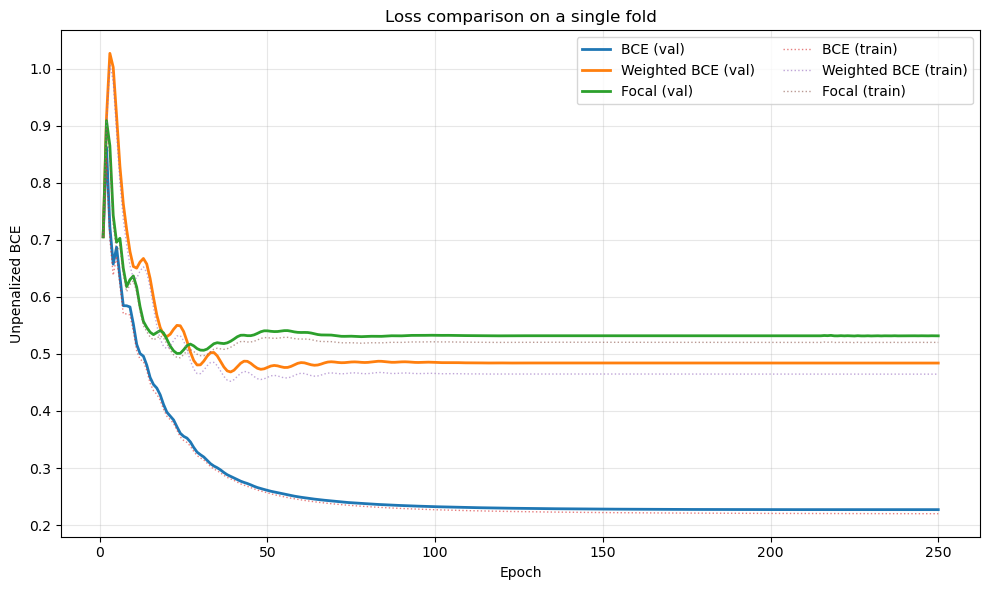

Figure saved to: C:\Users\alexb\OneDrive - Université Libre de Bruxelles\MA2 EPFL\CS-433\Projects\Project 1\notebook\picture\loss_compare_fold.png


In [8]:
# Plot comparison curves and save
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
T = np.arange(1, hist_bce["train_bce"].size + 1)
# Validation BCE
plt.plot(T, hist_bce["val_bce"], label="BCE (val)", lw=2)
plt.plot(T, hist_wb["val_bce"], label="Weighted BCE (val)", lw=2)
plt.plot(T, hist_foc["val_bce"], label="Focal (val)", lw=2)
# Optionally also show train curves faintly
plt.plot(T, hist_bce["train_bce"], label="BCE (train)", lw=1, ls=":", alpha=0.6)
plt.plot(T, hist_wb["train_bce"], label="Weighted BCE (train)", lw=1, ls=":", alpha=0.6)
plt.plot(T, hist_foc["train_bce"], label="Focal (train)", lw=1, ls=":", alpha=0.6)
plt.xlabel("Epoch")
plt.ylabel("Unpenalized BCE")
plt.title("Loss comparison on a single fold")
plt.grid(True, alpha=0.3)
plt.legend(ncol=2)

out_fig = (PICT_DIR / "loss_compare_fold.png").resolve()
plt.tight_layout()
plt.savefig(out_fig, dpi=150)
plt.show()
print("Figure saved to:", out_fig)